In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import illustris_python.groupcat as gc

In [4]:
basePath = "/hpcfs/home/ciencias/fisica/docentes/je.forero/Illustris-1/"

In [5]:
subhalo_fields = ['SubhaloMass','SubhaloSFRinRad', 'SubhaloPos', 'SubhaloVel', 'SubhaloParent', 'SubhaloGrNr']
subhalos = gc.loadSubhalos(basePath,135,fields=subhalo_fields)

In [6]:
halo_fields = ['GroupFirstSub', 'Group_M_Crit200', 'Group_R_Crit200', 
               'GroupNsubs', 'GroupPos', 'GroupVel', 'GroupFirstSub']
halos = gc.loadHalos(basePath, 135, fields=halo_fields)

In [7]:
mass_msun = halos['Group_M_Crit200'] * 1e10 / 0.704
n_in_halo = halos['GroupNsubs']

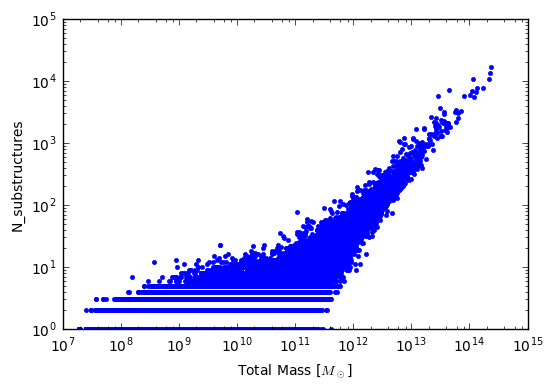

In [9]:
plt.xscale('log')
plt.yscale('log')
plt.plot(mass_msun,n_in_halo, '.')
plt.xlabel('Total Mass [$M_\odot$]')
plt.ylabel('N_substructures')

/lustre/apps/anaconda/3/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/lustre/apps/anaconda/3/lib/python3.5/site-packages/ipykernel/__main__.py:5: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


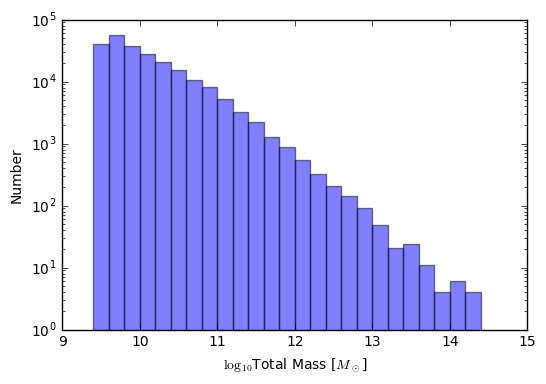

In [12]:
log_mass_msun = np.log10(mass_msun)
mass_limit = log_mass_msun > 9.5
number_limit = n_in_halo > 1

a = plt.hist(log_mass_msun[mass_limit], log=True, bins=np.linspace(9,15.0, 31.0), alpha=0.5, color='blue')
plt.xlabel('$\log_{10}$Total Mass [$M_\odot$]')
plt.ylabel('Number')

In [13]:
mass_sample = np.where(log_mass_msun > 9.5)
mass_sample = mass_sample[0]
n_in_sample = len(mass_sample)
print(n_in_sample)

229675


In [14]:
def get_masses(subhalos, halos, main_group_id=0):
    pos_in = subhalos['SubhaloPos'][subhalos['SubhaloGrNr']==main_group_id]
    vel_in = subhalos['SubhaloVel'][subhalos['SubhaloGrNr']==main_group_id]
    mass_in = subhalos['SubhaloMass'][subhalos['SubhaloGrNr']==main_group_id]
    total_mass = sum(mass_in)
    cm_vel = halos['GroupVel'][main_group_id].copy()
    if(total_mass>0.0):
        cm_vel[0] = sum(mass_in*vel_in[:,0])/sum(mass_in)
        cm_vel[1] = sum(mass_in*vel_in[:,1])/sum(mass_in)
        cm_vel[2] = sum(mass_in*vel_in[:,2])/sum(mass_in)
    
    sigma_x = vel_in[:,0].std()
    sigma_y = vel_in[:,1].std()
    sigma_z = vel_in[:,2].std()
    sigma_vel_in_3D = np.sqrt(sigma_x**2 + sigma_y**2 + sigma_z**2)
    sigma_vel_in_1D = sigma_x
    sim_mass_group = halos['Group_M_Crit200'][main_group_id] * 1e10 / 0.704 # Msun
    sim_radius_group = halos['Group_R_Crit200'][main_group_id] * 1E-3/ 0.704 # kpc
    sim_vel_group = halos['GroupVel'][main_group_id] # km/s
    norm_sim_vel_group = np.sqrt(np.sum(sim_vel_group**2))
    norm_cm_vel = np.sqrt(np.sum(cm_vel**2))
    delta_vel = np.sqrt(np.sum((sim_vel_group - cm_vel)**2))#km/s
    delta_dot = np.sum(sim_vel_group*cm_vel)/(norm_cm_vel * norm_sim_vel_group)
    return np.size(pos_in), sim_mass_group, sim_radius_group, sigma_vel_in_1D, sigma_vel_in_3D, delta_vel, delta_dot

In [16]:
full_id_list = np.arange(n_in_sample, dtype=int)
n_in_sample = 4000
n_sub_sample = int(n_in_sample/10)
print(n_sub_sample)
sub_sample_id = np.random.choice(full_id_list, size=n_sub_sample)

virial_masses = np.zeros(n_sub_sample)
sim_nsub_halo = np.zeros(n_sub_sample)
sim_masses = np.zeros(n_sub_sample)
sim_radius = np.zeros(n_sub_sample)
sim_sigma_1D = np.zeros(n_sub_sample)
sim_sigma_3D = np.zeros(n_sub_sample)
delta_vel = np.zeros(n_sub_sample)
delta_dot = np.zeros(n_sub_sample)


for i in range(n_sub_sample):
    A = get_masses(subhalos, halos, main_group_id=sub_sample_id[i])
    sim_nsub_halo[i], sim_masses[i], sim_radius[i], sim_sigma_1D[i], sim_sigma_3D[i], delta_vel[i],delta_dot[i]  = A
    if not i%(n_sub_sample//10):
        print(i, n_sub_sample)
        
ii = sim_nsub_halo > 0
a = np.array([sim_nsub_halo[ii], sim_masses[ii], sim_radius[ii], 
              sim_sigma_1D[ii], sim_sigma_3D[ii], delta_vel[ii], delta_dot[ii]])
a = a.T
np.savetxt('../data/summary.dat', a, 
           fmt="%d %e %f %f %f %f %f", 
               header='n_subhalo mass[Msun] radius[Mpc] sigma_p sigma_3D cm_vel_offset[km/s] dot_vel')

400
0 400
40 400
80 400
120 400
160 400
200 400
240 400
280 400
320 400
360 400


In [17]:
data = np.loadtxt('../data/summary.dat')
sim_nsub_halo, sim_masses, sim_radius, sim_sigma_1D, sim_sigma_3D,delta_vel, delta_dot = data.T
alpha = 2.5
virial_masses =1E6 * (sim_sigma_3D/np.sqrt(alpha))**3

0


(0.008, 1)

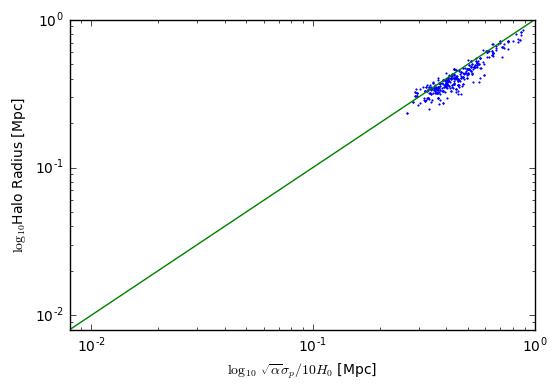

In [18]:
plt.xscale('log')
plt.yscale('log')
ii = sim_nsub_halo>10
print(np.count_nonzero(~ii))
alpha =2.5
H_0 = 70.4
plt.plot(np.sqrt(alpha)*sim_sigma_1D[ii]/(10*H_0), sim_radius[ii] , '.', markersize=2)
x = np.logspace(-3, 2, num=20)
plt.plot(x,x)
plt.xlabel(r'$\log_{10}$ $\sqrt{\alpha}\sigma_p / 10 H_0$ [Mpc]')
plt.ylabel('$\log_{10}$Halo Radius [Mpc]')
ax = plt.axes()
ax.set_ylim([8E-3, 1])
ax.set_xlim([8E-3, 1])

0


(0.01, 100000.0)

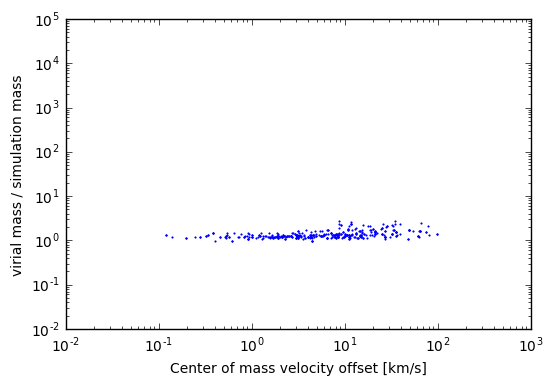

In [19]:
#print(delta_vel)
plt.xscale('log')
plt.yscale('log')
ii = sim_nsub_halo>10
print(np.count_nonzero(~ii))
alpha =2.5
H_0 = 70.4
plt.plot(delta_vel[ii], (virial_masses[ii]+1)/sim_masses[ii] , '.', markersize=2)
x = np.logspace(-3, 2, num=20)
plt.xlabel(r'Center of mass velocity offset [km/s]')
plt.ylabel('virial mass / simulation mass')
ax = plt.axes()
ax.set_xlim([1E-2, 1E3])
ax.set_ylim([1E-2, 1E5])

0


(1, 20)

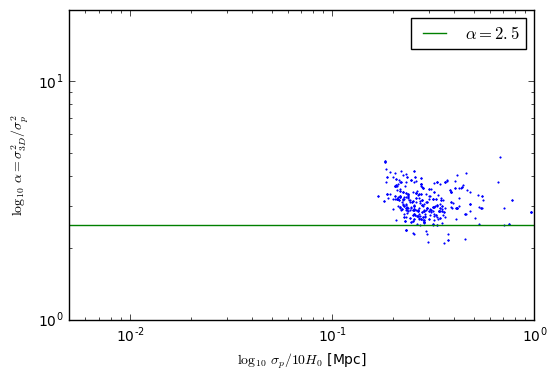

In [20]:
plt.xscale('log')
plt.yscale('log')
ii = sim_nsub_halo>10
print(np.count_nonzero(~ii))
H_0 = 70.4
plt.plot(sim_sigma_1D[ii]/(10*H_0), sim_sigma_3D[ii]**2/sim_sigma_1D[ii]**2, '.', markersize=2)
x = np.logspace(-3, 2, num=20)
y = np.ones(20) * 2.5
plt.plot(x,y, label=r'$\alpha=2.5$')
plt.xlabel('$\log_{10}$ $\sigma_p / 10 H_0$ [Mpc]')
plt.ylabel(r'$\log_{10}$ $\alpha = \sigma_{3D}^2/\sigma_{p}^2$')
plt.legend()
ax = plt.axes()
ax.set_xlim([5E-3, 1])
ax.set_ylim([1, 20])

(100000000.0, 100000000000000.0)

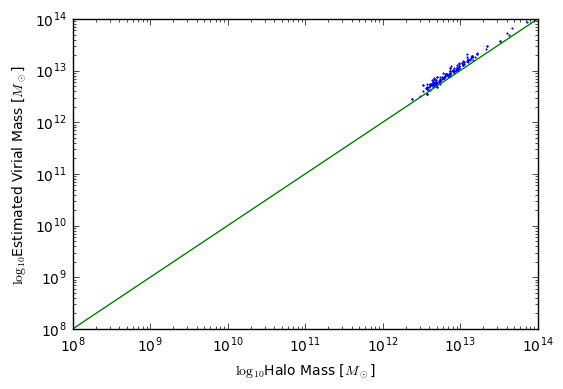

In [21]:
plt.xscale('log')
plt.yscale('log')
ii = (sim_nsub_halo>10) & (delta_vel<5.0)
plt.plot(sim_masses[ii], virial_masses[ii], '.', markersize=2)
x = np.logspace(7, 14, num=20)
plt.plot(x,x)
plt.ylabel('$\log_{10}$Estimated Virial Mass [$M_\odot$]')
plt.xlabel('$\log_{10}$Halo Mass [$M_\odot$]')
ax = plt.axes()
ax.set_ylim([1E8, 1E14])
ax.set_xlim([1E8, 1E14])

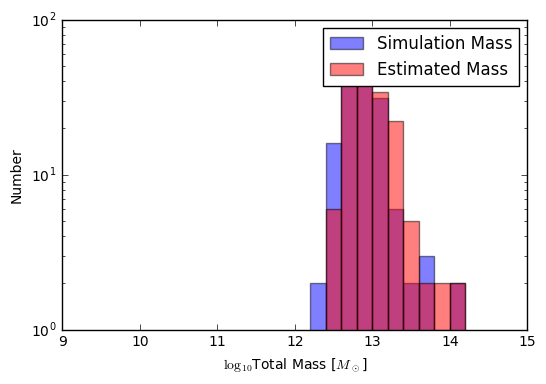

In [23]:
ii = (sim_nsub_halo > 10) & (delta_vel<5.0)
a = plt.hist(np.log10(sim_masses[ii]+1.0), log=True, bins=np.linspace(9,15.0, 31), alpha=0.5, 
             color='blue', label='Simulation Mass')
a = plt.hist(np.log10(virial_masses[ii]+1.0), log=True, bins=np.linspace(9,15.0, 31), alpha=0.5, 
             color='red', label='Estimated Mass')
plt.xlabel('$\log_{10}$Total Mass [$M_\odot$]')
plt.ylabel('Number')
plt.legend()